# Анализ системы метрик приложения

Приложение Procrastinate Pro+ предоставляет пользователям доступ к развлекательному контенту: видео, подкастам и блогам. Пользователи могут выбрать несколько пакетов контента. Пакеты различаются по цене, объёму и содержанию.

К началу лета в приложении появился новый вид контента — спортивный. С его помощью менеджеры стремятся расширить аудиторию, добавив в неё пользователей, которые увлекаются спортом и здоровым образом жизни.

К запуску нового контента была скорректирована маркетинговая стратегия привлечения пользователей. Согласно бизнес-модели продукта, привлечение должно окупиться за первые 28 дней (4 недели).

После запуска нового контента и изменения стратегии интерес к продукту в целом вырос, но выручка начала стагнировать. Нужно разобраться, почему это происходит.

Задачи:
- провести анализ юнит-экономики продукта в динамике за первые 28 дней;
- разобраться в причинах стагнации выручки;
- определить, какие источники привлечения приносят прибыль, а какие не выходят на уровень окупаемости;
- дать рекомендации отделу маркетинга.


### Данные

Данные собраны в трёх датасетах.

1. Датасет `ppro_visits.csv` — информация о посещениях приложения пользователями, которые зарегистрировались с 1 апреля 2024 года по 30 ноября 2024 года:
    - `user_id` — уникальный идентификатор пользователя;
    - `region` — страна пользователя;
    - `device` — категория устройства пользователя;
    - `channel` — идентификатор рекламного источника, из которого пришёл пользователь;
    - `session_start` — дата и время начала сессии;
    - `session_end` — дата и время окончания сессии.

2. Датасет `ppro_orders.csv` — информация о покупках:
    - `user_id` — уникальный идентификатор пользователя, который сделал покупку;
    - `event_dt` — дата и время покупки;
    - `revenue` — выручка.

3. Датасет `ppro_costs.csv` — информация о затратах на маркетинг:
    - `dt` — дата
    - `channel` — идентификатор рекламного источника;
    - `costs` — затраты на этот рекламный источник в этот день.
    
### План проекта
- Загрузить и предобработать данные.
- Подготовить данные для когортного анализа.
- Рассчитать и проанализировать метрики вовлечённости в продукт.
- Рассчитать и проанализировать финансовые метрики CAC, LTV и ROI за первые 28 дней с момента привлечения.
- Исследовать метрики в разрезе источника привлечения.
- Рассчитать период окупаемости маркетинговых вложений.
- Сформулировать выводы и рекомендации.


## Загрузка и предобработка данных


In [4]:
# Эта ячейка исправит проблему SSL если она есть
import ssl
try:
    # Пробуем нормальный режим
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [5]:
# Импортируем основные библиотеки, необходимые для нашего анализа

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [6]:
# Сохраним датасеты в переменные

visits = pd.read_csv('https://code.s3.yandex.net/datasets/ppro_visits.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/ppro_orders.csv')
costs = pd.read_csv('https://code.s3.yandex.net/datasets/ppro_costs.csv')

In [7]:
visits.head(5)

,user_id,region,device,channel,session_start,session_end
0,631105188566,India,desktop,MediaTornado,2024-04-01 03:48:00,2024-04-01 04:19:00
1,892885906464,India,tv,RocketSuperAds,2024-04-01 00:47:00,2024-04-01 01:14:00
2,517003690029,India,mobile,MediaTornado,2024-04-01 17:31:00,2024-04-01 17:53:00
3,185156659289,India,mobile,MediaTornado,2024-04-01 14:36:00,2024-04-01 14:51:00
4,409503040345,India,mobile,RocketSuperAds,2024-04-01 08:25:00,2024-04-01 08:45:00


In [8]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161865 entries, 0 to 161864
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        161865 non-null  int64 
 1   region         161865 non-null  object
 2   device         161865 non-null  object
 3   channel        161865 non-null  object
 4   session_start  161865 non-null  object
 5   session_end    161865 non-null  object
dtypes: int64(1), object(5)
memory usage: 7.4+ MB


Промежуточные выводы:
- Датасет содержит 161865 строк и 6 столбцов. 
- Пропусков нет. 
- Столбцы `session_start`и `session_end` содержат информацию о дате, но тип данных в этих столбцах `object`. Далее приведем к типу `datetime`. В определенных задач потребуется также извелкать конкретно месяцы из дат. 

In [9]:
# Приводим столбцы с датами к необходимому типу
visits['session_start'] = pd.to_datetime(visits['session_start']).dt.normalize()
visits['session_end'] = pd.to_datetime(visits['session_end']).dt.normalize()

visits.dtypes

user_id                   int64
region                   object
device                   object
channel                  object
session_start    datetime64[ns]
session_end      datetime64[ns]
dtype: object

In [10]:
orders.head(5)

,user_id,event_dt,revenue
0,771951256319,2024-04-01 05:56:26,2.99
1,829942381059,2024-04-01 14:55:02,2.99
2,727879856738,2024-04-01 22:15:09,14.99
3,481270888930,2024-04-01 06:05:14,2.99
4,844695029762,2024-04-01 01:19:52,2.99


In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33893 entries, 0 to 33892
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   33893 non-null  int64  
 1   event_dt  33893 non-null  object 
 2   revenue   33893 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 794.5+ KB


Промежуточные выводы:
- Датасет содержит 33893 строк и 3 столбца. 
- Пропусков нет. 
- Столбец `event_dt` содержат информацию о дате, но тип данных в нем  `object`. Далее приведем к типу `datetime`. В определенных задач потребуется также извелкать конкретно месяцы из дат. 

In [12]:
# Приводим столбец с датами к необходимому типу
orders['event_dt'] = pd.to_datetime(orders['event_dt']).dt.normalize()


orders.dtypes

user_id              int64
event_dt    datetime64[ns]
revenue            float64
dtype: object

In [13]:
costs.head(5)

,dt,channel,costs
0,2024-04-01,FaceBoom,124.938874
1,2024-04-02,FaceBoom,88.147779
2,2024-04-03,FaceBoom,120.779457
3,2024-04-04,FaceBoom,98.981253
4,2024-04-05,FaceBoom,109.044760


In [14]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       976 non-null    object 
 1   channel  976 non-null    object 
 2   costs    976 non-null    float64
dtypes: float64(1), object(2)
memory usage: 23.0+ KB


Промежуточные выводы:
- Датасет содержит 976 строк и 3 столбца. 
- Пропусков нет. 
- Столбец `dt` содержат информацию о дате, но тип данных в нем  `object`. Далее приведем к типу `datetime`. В определенных задач потребуется также извелкать конкретно месяцы из дат. 

In [15]:
# Приводим столбец с датами к необходимому типу
costs['dt'] = pd.to_datetime(costs['dt']).dt.normalize()

costs.dtypes

dt         datetime64[ns]
channel            object
costs             float64
dtype: object

Проверим также на всякий случай датасеты на наличие дубликатов.

In [16]:
visits.nunique()

user_id          74856
region               1
device               3
channel              4
session_start      244
session_end        245
dtype: int64

In [17]:
visits.duplicated(keep = 'first').sum()

np.int64(0)

In [18]:
orders.nunique()

user_id     6889
event_dt     244
revenue        5
dtype: int64

In [19]:
orders.duplicated(keep = 'first').sum()

np.int64(0)

In [20]:
costs.nunique()

dt         244
channel      4
costs      833
dtype: int64

In [21]:
costs.duplicated(keep = 'first').sum()

np.int64(0)

Промежуточный итог по предобработке данных. 
- Во всех датасетах были преобразоаны типы данных в столбцах с датами из `object` в `datetime64[ns]`, а именно у датасета `visits` столбцы `session_start` и `session_end`, у датасета `orders` столбец `event_dt` и у датасета `costs` столбец `dt`. 
- Все датасеты не имеют пропусков. 
- Датасеты имеют дубликаты, но они допустимы и находятся в рамках нормы. По связке всех столбцов также не нашлось ни одной строчки, которая являлась бы полным дубликатом какой-либо другой строчки датасетов. 
Можем переходить к следующему шагу. 

## Подготовка данных к когортному анализу

Подготовим данные к когортному анализу с учётом того, что мы будем изучать окупаемость привлечения пользователей за первые 28 дней.

Для каждого пользователя найдем:
- дату первой сессии (дата привлечения пользователя, `first_dt`);
- канал привлечения (`first_channel`);
- стоимость привлечения пользователя (`cac`).

Результаты сохраним в новой таблице `profiles`.

Добавим к данным с событиями и покупками информацию о первом источнике привлечения и дату привлечения пользователя из созданной таблицы. После этого рассчитаем дневной лайфтайм для каждого события или покупки и добавим в таблицу в виде целого числа. В дальнейшем при проведении когортного анализа будем использовать информацию о первом источнике привлечения пользователя.

In [22]:
# Находим дату первой сессии (дата привлечения пользователя, first_dt
first_visit = visits[['session_start', 'user_id', 'channel']].sort_values('session_start', ascending = True).groupby('user_id').first().reset_index().rename(columns = {'session_start':'first_dt',
                                                                                                                 'channel':'first_channel'})

# Рассчитываем кол-во привлеченных клиентов (знаменатель САС), сохраняем в таблицу users_count
users_count = first_visit.groupby(['first_dt','first_channel'])['user_id'].nunique().reset_index(name = 'user_count')

# Объединяем таблицы costs_grouped и users_count, чтобы рассчитать CAC
costs_grouped = pd.merge(costs, users_count,left_on = ['dt','channel'], right_on = ['first_dt','first_channel'] , how = 'left')

# Рассчитываем САС
costs_grouped['cac'] = costs_grouped['costs']/costs_grouped['user_count']

# Объединяем таблицы costs_grouped и profiles
profiles = pd.merge(first_visit,costs_grouped[['cac', 'first_dt', 'first_channel']], on =['first_dt', 'first_channel'], how = 'left' )

display(profiles.head(), profiles.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74856 entries, 0 to 74855
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        74856 non-null  int64         
 1   first_dt       74856 non-null  datetime64[ns]
 2   first_channel  74856 non-null  object        
 3   cac            74856 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.3+ MB


,user_id,first_dt,first_channel,cac
0,26034876,2024-05-29,FaceBoom,0.953250
1,69890364,2024-06-28,RocketSuperAds,0.604917
2,75610104,2024-06-09,FaceBoom,1.196159
3,76692397,2024-10-21,FaceBoom,1.147967
4,80224421,2024-06-21,FaceBoom,1.208981


None

Мы создали таблицу `profiles` согласно заданию. 
- Таблица имеет 74856 строк и 4 столбца.
- `user_id` - уникальный идентификатор пользователя. 
- `first_dt` - дата первой сессии (дата привлечения пользователя), найденная по столбцу `session_start` таблицы `visits`.
- `first_channel` - канал привлечения
- `cac` - метрика CAC, рассчитанная по формуле маркетинговый затраты/кол-во привлеченных пользователей.

Перейдем к выполнению второй части задачи. 

In [23]:
# Присоединяем к таблице visits новую таблицу profiles
visits = pd.merge(visits, profiles, on = 'user_id', how = 'left')

# Считаем лайфтайм 
visits['lifetime'] = (visits['session_start'] - visits['first_dt']).dt.days
visits.head()

,user_id,region,device,channel,session_start,session_end,first_dt,first_channel,cac,lifetime
0,631105188566,India,desktop,MediaTornado,2024-04-01,2024-04-01,2024-04-01,MediaTornado,0.249160,0
1,892885906464,India,tv,RocketSuperAds,2024-04-01,2024-04-01,2024-04-01,RocketSuperAds,0.886429,0
2,517003690029,India,mobile,MediaTornado,2024-04-01,2024-04-01,2024-04-01,MediaTornado,0.249160,0
3,185156659289,India,mobile,MediaTornado,2024-04-01,2024-04-01,2024-04-01,MediaTornado,0.249160,0
4,409503040345,India,mobile,RocketSuperAds,2024-04-01,2024-04-01,2024-04-01,RocketSuperAds,0.886429,0


In [24]:
# Присоединяем к таблице visits новую таблицу profiles
orders = pd.merge(orders, profiles, on = 'user_id', how = 'left')

# Считаем лайфтайм 
orders['lifetime'] = (orders['event_dt'] - orders['first_dt']).dt.days
orders.head()

,user_id,event_dt,revenue,first_dt,first_channel,cac,lifetime
0,771951256319,2024-04-01,2.99,2024-04-01,FaceBoom,0.939390,0
1,829942381059,2024-04-01,2.99,2024-04-01,FaceBoom,0.939390,0
2,727879856738,2024-04-01,14.99,2024-04-01,FaceBoom,0.939390,0
3,481270888930,2024-04-01,2.99,2024-04-01,TipTop,0.742467,0
4,844695029762,2024-04-01,2.99,2024-04-01,FaceBoom,0.939390,0


Мы объединили таблицы `visits` и `orders` с `profile` и рассчитали `lifetime`. 

## Анализ месячной динамики основных метрик продукта

**Задача 1**. Начните анализ данных с изучения динамики активности пользователей и их вовлечённости в продукт. Рассчитайте по всем данным значения DAU, MAU и Stickiness и визуализируйте их. Активными считайте всех пользователей, которые взаимодействовали с приложением.

**Задача 2**. В разрезе каждого месяца привлечения новых пользователей рассчитайте:
- Среднюю стоимость привлечения пользователя (CAC).
- Значение LTV и ROI с учётом покупок, совершённых за 28 дней с момента привлечения.

Здесь и далее при расчёте LTV и ROI учитывайте всех привлечённых пользователей когорты.

Визуализируйте метрики и сформулируйте небольшой промежуточный вывод. Сделайте акцент на общей динамике изменения метрик с учётом появления нового контента в начале лета.

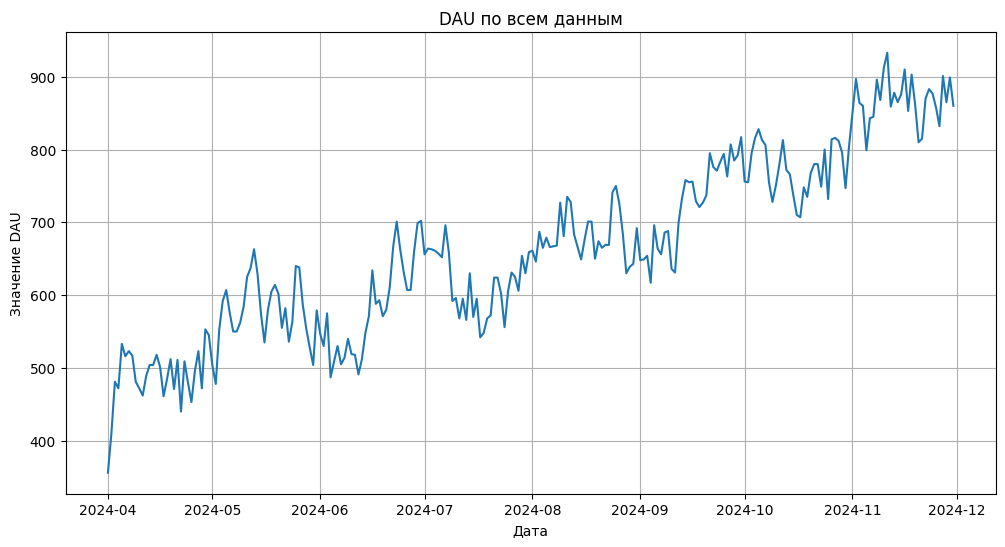

In [25]:
# Задача 1. Рассчитываем DAU по всем данным для активных пользователей
dau = visits.groupby('session_start')['user_id'].nunique().reset_index(name = 'DAU')


plt.figure(figsize=(12,6))
plt.plot(dau['session_start'], dau['DAU'])
plt.grid(True)
plt.title('DAU по всем данным')
plt.xlabel('Дата')
plt.ylabel('Значение DAU')
plt.show()

Промежуточный итог:
- График DAU является восходящим, имеет волнообразные колебания. В целом динамика хорошая, количество пользователей растет, это может свидетельствовать об эффективной работе рекламных каналов. 

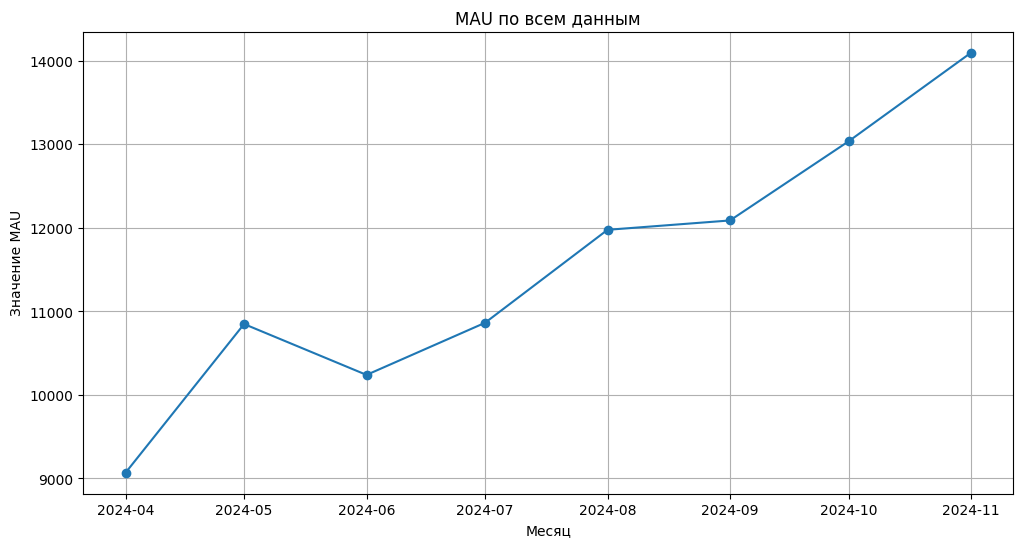

In [26]:
# Задача 1. Рассчитываем MAU по всем данным для активных пользователей
mau = visits
mau['session_start'] = mau['session_start'].dt.to_period('M').dt.to_timestamp()
mau = mau.groupby('session_start')['user_id'].nunique().reset_index(name = 'MAU')

plt.figure(figsize=(12,6))
plt.plot(mau['session_start'], mau['MAU'], marker = 'o')
plt.grid(True)
plt.title('MAU по всем данным')
plt.xlabel('Месяц')
plt.ylabel('Значение MAU')
plt.show()

Промежуточный итог: 
- График MAU также восходящий, имеет небольшие колебания. Это также хороший показатель эффективной работы продукта и притока новых пользователей (или старых пользователей, которые вновь вернулись в продукт). 

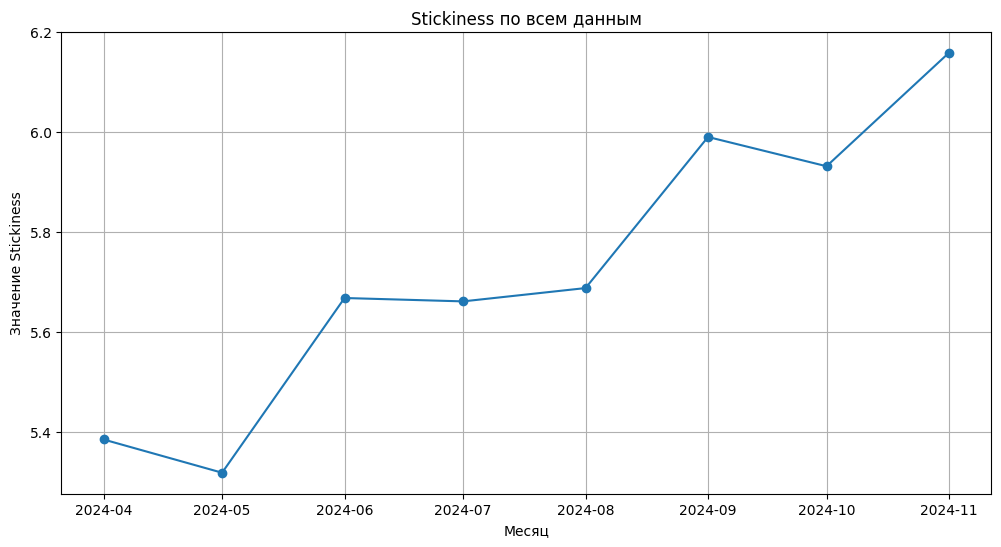

In [27]:
# Задача 1. Рассчитываем Stickiness по всем данным для активных пользователей

# Приводим дату в таблице dau к месяцу
dau['session_start'] = dau['session_start'].dt.to_period('M').dt.to_timestamp()

# Сичтаем среднемесячный DAU
dau_monthly_average = dau.groupby('session_start')['DAU'].mean().reset_index(name = 'dau_monthly_average')

# Объединяем в таблице stickiness таблицы dau_monthly_average и mau
stickiness = pd.merge(dau_monthly_average, mau, on =  'session_start', how = 'left')

# Считаем метрику stickiness как отношение среднемесячного DAU к MAU *100
stickiness['stickiness'] = stickiness['dau_monthly_average']/stickiness['MAU']*100

# Визуализируем метрику stickiness
plt.figure(figsize=(12,6))
plt.plot(stickiness['session_start'], stickiness['stickiness'], marker = 'o')
plt.title('Stickiness по всем данным')
plt.xlabel('Месяц')
plt.ylabel('Значение Stickiness')
plt.grid(True)
plt.show()

Промежуточный итог:
- Stickiness также имеет восходящий тренд и положительную динамику. Напомним, что с помощью этой метрики можно условно оценить долю месячной аудитории продукта, которая пользуется им на ежедневной основе. Получается, что нашим продуктом пользуются на ежедневной основе, количество вовлеченных пользователей растет. 

In [28]:
# Задача 2. Значение LTV и ROI с учётом покупок, совершённых за 28 дней с момента привлечения

# В отдельные столбцы выделяем первый месяц из даты начала привлечения
orders['first_month'] = orders['first_dt'].dt.to_period('M').dt.to_timestamp()
visits['first_month'] = visits['first_dt'].dt.to_period('M').dt.to_timestamp()
costs['first_month'] = costs['dt'].dt.to_period('M').dt.to_timestamp()

# Считаем общую вручку по месяцам привлечения
total_revenue = orders[(orders['lifetime']<28)&(orders['first_month'] < '2024-11-01')].groupby('first_month')['revenue'].sum().reset_index(name = 'total_revenue')

# Считаем общее число пользователей по месяцам привлечения 
total_users = visits[(visits['lifetime']<28)&(visits['first_month'] < '2024-11-01')].groupby('first_month')['user_id'].nunique().reset_index(name = 'total_users')

# Объединяем таблицы с общей выручкой и общим числом посетителей, чтобы найти затем метрики
metrics = pd.merge(total_revenue, total_users, how = 'inner', on = 'first_month')

# Считаем общие маркетинговые затраты по месяцам привлечения
cac = costs.groupby('first_month')['costs'].sum().reset_index(name = 'total_costs')

# Объединяем таблицы с общей выручкой и общим числом посетителей, чтобы найти затем метрики
metrics = pd.merge(metrics, cac, on = 'first_month', how = 'inner')

# Считаем метрики
metrics['CAC'] = metrics['total_costs']/metrics['total_users']

metrics['LTV'] = metrics['total_revenue']/metrics['total_users']

metrics['ROI'] = (metrics['LTV'] - metrics['CAC'])/metrics['CAC']*100

display(metrics)

,first_month,total_revenue,total_users,total_costs,CAC,LTV,ROI
0,2024-04-01,7425.63,9069,6663.052333,0.734706,0.818793,11.444870
1,2024-05-01,8141.76,9789,7327.775412,0.748572,0.831725,11.108209
2,2024-06-01,7447.84,8719,8492.116887,0.973978,0.854208,-12.297015
3,2024-07-01,9991.41,8742,9217.078561,1.054344,1.142920,8.401051
4,2024-08-01,10367.05,9518,10999.013650,1.155601,1.089205,-5.745639
5,2024-09-01,10085.88,9198,10838.014747,1.178301,1.096530,-6.939783
6,2024-10-01,11449.71,9520,12595.403113,1.323047,1.202701,-9.096121


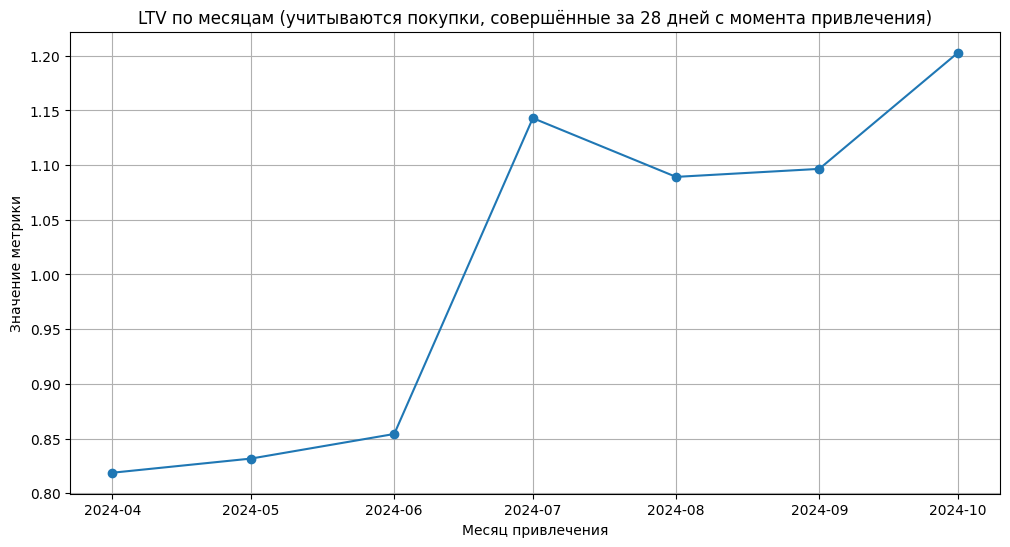

In [29]:
# Визуализируем CAC и LTV

plt.figure(figsize=(12, 6))
plt.plot(metrics['first_month'], metrics['LTV'], marker = 'o')


plt.grid(True)
plt.title('LTV по месяцам (учитываются покупки, совершённые за 28 дней с момента привлечения)')
plt.xlabel('Месяц привлечения')
plt.ylabel('Значение метрики')
plt.show()

Промежуточный итог:
- Можно заметить, что LTV в начале периода очень низкий, с начала лета, когда была скорректирована маркетинговая стратегия и с появлением нового вида контента, LTV очень сильно вырос, далее он стабилизируется. 

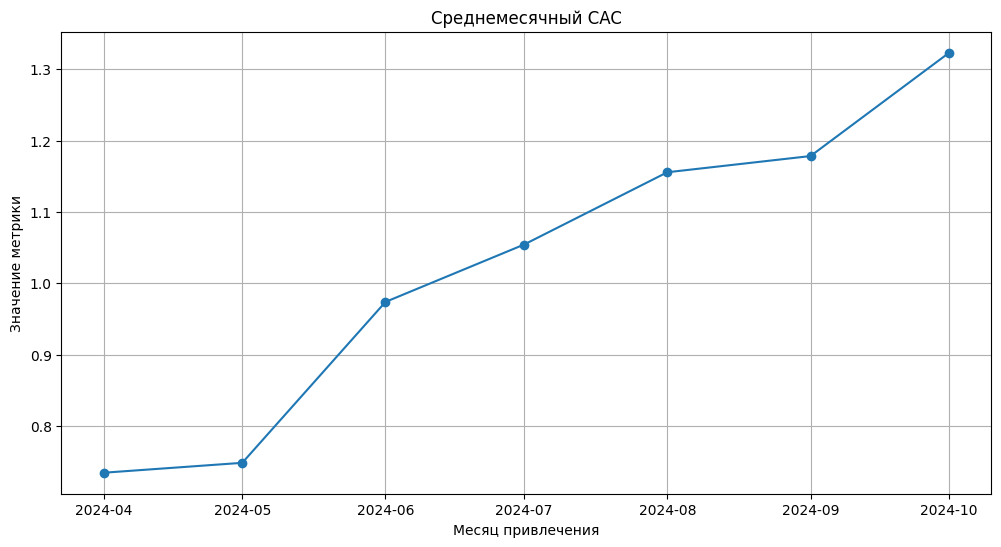

In [30]:
# Визуализируем CAC

plt.figure(figsize=(12, 6))
plt.plot(metrics['first_month'], metrics['CAC'], marker = 'o')

plt.grid(True)
plt.title('Среднемесячный CAC')
plt.xlabel('Месяц привлечения')
plt.ylabel('Значение метрики')
plt.show()

Промежуточный итог:
- Можно заметить четкую тенденцию в росте метрики CAC на протяжении всего периода, даже после внедрения новой маркетинговой стратегии метрика продолжила свой рост. 

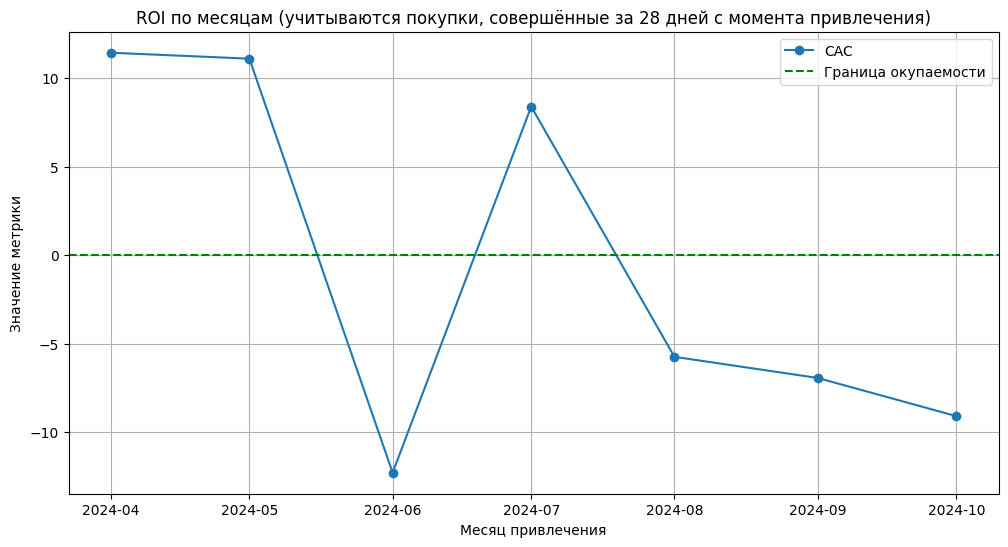

In [31]:
# Визуализируем ROI
plt.figure(figsize=(12, 6))
plt.plot(metrics['first_month'], metrics['ROI'], marker = 'o', label = 'CAC')
plt.axhline(y=0, color='green', linestyle='--', label='Граница окупаемости')

plt.grid(True)
plt.title('ROI по месяцам (учитываются покупки, совершённые за 28 дней с момента привлечения)')
plt.xlabel('Месяц привлечения')
plt.ylabel('Значение метрики')
plt.legend()
plt.show()

Промежуточный итог:
- Можно заметить, что отдел маркетинга работает нелохо, приложение популярно среди пользователей. Также новая маркетинговой стратегия окупается только в июле, в остальное время она нерентабельна, что говорит о том, что затраты на клиента не окупаются. Возможно это связано с сильно выросшими затратами с начала лета - с запуском новой маркетинговой кампании. Далее проанализиурем метрики в разрезе источников привлечения и выявим возможные проблемы на более детальном уровне.  

## Анализ метрик в разрезе источника привлечения

Теперь необходимо разобраться, какие источники привлечения перспективны, а какие за 28 дней не окупились.

**Задача 1**. Определим самые популярные источники привлечения:
- Посчитаем общее число привлечённых пользователей для каждого источника.
- Визуализиурем динамику набора новых пользователей по дням в каждом источнике.
- Рассчитаем и визуализируйте динамику DAU, MAU и Stickiness по источникам привлечения.

**Задача 2**. Изучим динамику изменения метрик на 28-й день в разрезе источника. Проведем анализ с выделением недельных когорт по дате привлечения. Рассчитайте и визуализируйте:
- Скользящее удержание на 14-й день с момента привлечения (за период с 14-го по 28-й день).
- Конверсию в покупку.

Недельную динамику затрат на маркетинг по каждому источнику привлечения.
Динамику среднего CAC, значений LTV и ROI.

По результатам проведем анализ рекламных каналов. Дадим общую характеристику каждому рекламному каналу по рассчитанным метрикам. Определим, какие рекламные каналы не вышли на уровень окупаемости за ожидаемый период, и предположите почему.


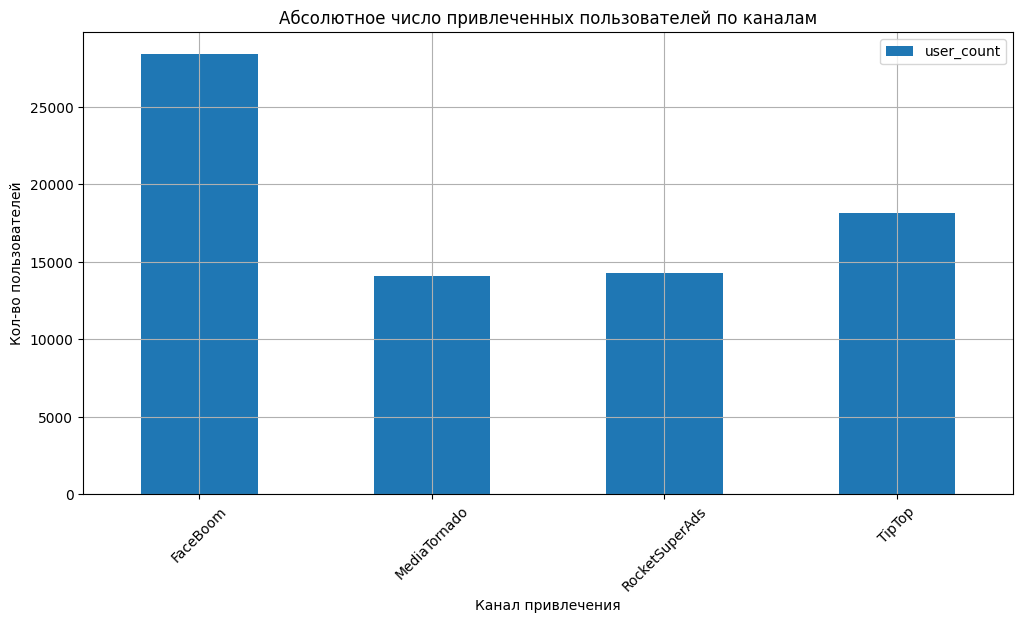

In [32]:
# Задача 1. Считаем общее число привлеченных пользователей для каждого источника. 

profiles_total_per_channel = profiles.groupby('first_channel')['user_id'].nunique().reset_index(name = 'user_count')

# Считаем общее число пользователей
profiles_total_per_channel['total_users'] = profiles['user_id'].nunique()

#Считаем относительное значение кол-ва пользователей
profiles_total_per_channel['user_perc'] =  round(profiles_total_per_channel['user_count']/profiles_total_per_channel['total_users']*100, 2)

# Визуализируем абсолютное значение кол-ва пользователей 
profiles_total_per_channel.plot(kind = 'bar', x = 'first_channel', y = 'user_count', rot = 45, figsize=(12,6))

plt.grid(True)
plt.title('Абсолютное число привлеченных пользователей по каналам')
plt.xlabel('Канал привлечения')
plt.ylabel('Кол-во пользователей')
plt.show()


Text(0, 0.5, 'Доля пользователей')

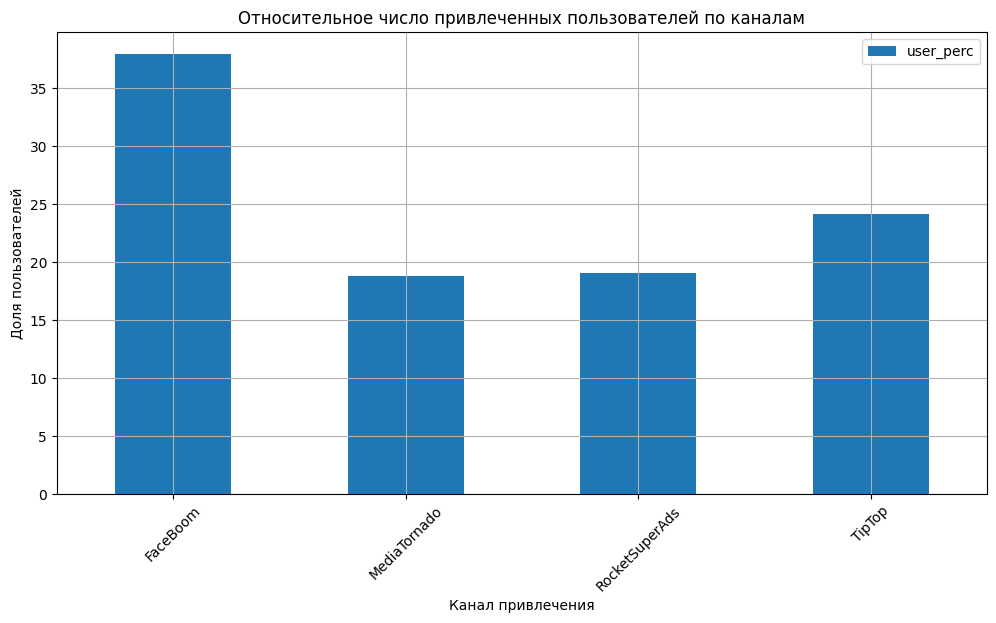

In [33]:
# Визуализируем относительное значение кол-ва пользователей 
profiles_total_per_channel.plot(kind = 'bar', x = 'first_channel', y = 'user_perc', rot = 45, figsize=(12,6))

plt.grid(True)
plt.title('Относительное число привлеченных пользователей по каналам')
plt.xlabel('Канал привлечения')
plt.ylabel('Доля пользователей')

In [34]:
# Выведем таблицу с точными значениями абсолютного и относительного количества пользователей 
display(profiles_total_per_channel)


,first_channel,user_count,total_users,user_perc
0,FaceBoom,28401,74856,37.94
1,MediaTornado,14080,74856,18.81
2,RocketSuperAds,14257,74856,19.05
3,TipTop,18118,74856,24.20


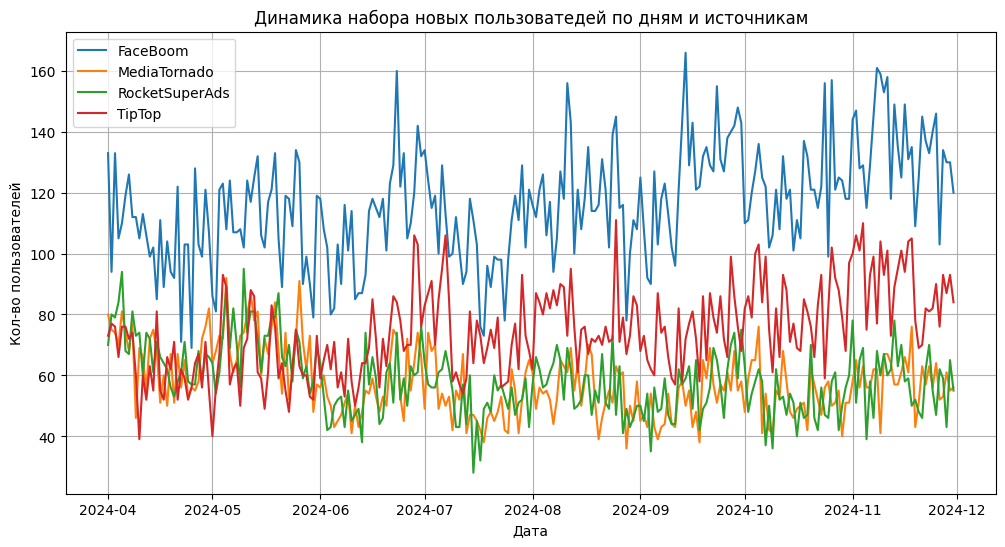

In [35]:
# Задача 1. Визуализируем динамику набора новых пользователей по дням в каждом источнике.

profiles_total_per_day_channel = profiles.groupby(['first_dt','first_channel'])['user_id'].nunique().reset_index(name = 'user_count')


plt.figure(figsize=(12,6))

for channel in profiles_total_per_day_channel['first_channel'].unique():
    df_plot = profiles_total_per_day_channel[profiles_total_per_day_channel['first_channel']== channel]
    plt.plot(df_plot['first_dt'], df_plot['user_count'], label = channel)
    
plt.title('Динамика набора новых пользоватедей по дням и источникам')
plt.xlabel('Дата')
plt.ylabel('Кол-во пользователей')
plt.legend()
plt.grid(True)
plt.show()

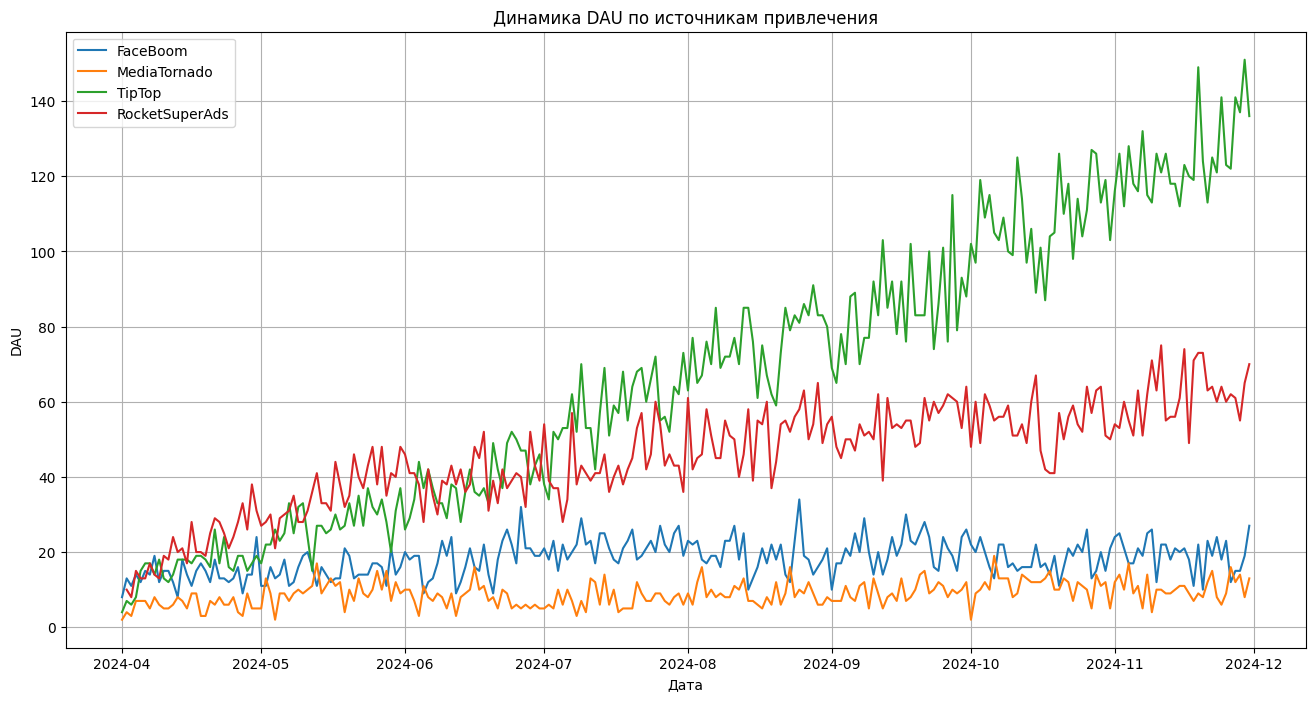

In [36]:
# Задача 1. Рассчитаем и визуализируем динамику DAU по источникам привлечения.

dau_per_channel = orders.groupby(['event_dt', 'first_channel'])['user_id'].nunique().reset_index(name = 'DAU')

plt.figure(figsize=(16,8))

for channel in dau_per_channel['first_channel'].unique():
    df_plot = dau_per_channel[dau_per_channel['first_channel'] == channel]
    plt.plot(df_plot['event_dt'], df_plot['DAU'], label = channel)
plt.title('Динамика DAU по источникам привлечения')        
plt.xlabel('Дата')
plt.ylabel('DAU')
plt.legend()
plt.grid(True)
plt.show()

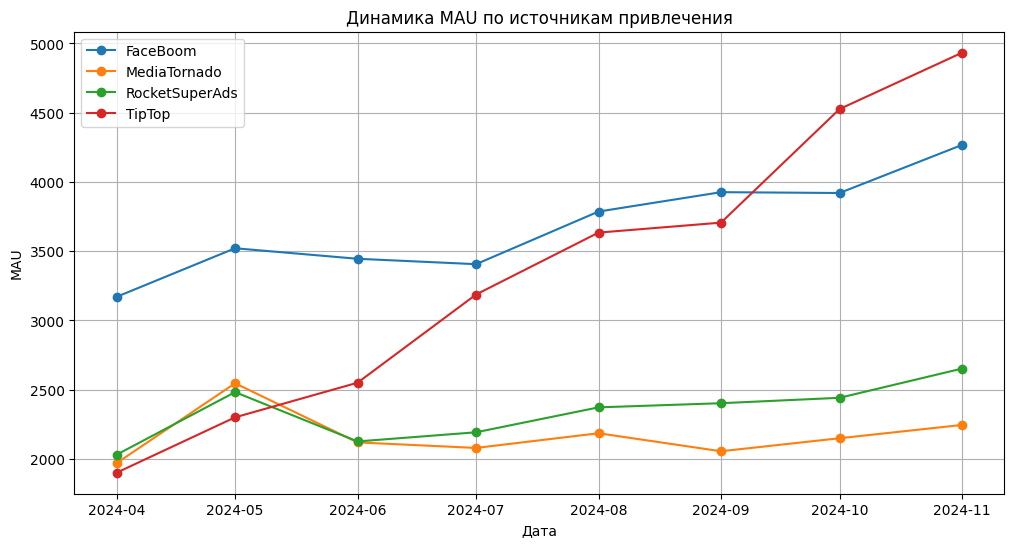

In [37]:
# Задача 1. Рассчитаем и визуализируем динамику MAU по источникам привлечения.
mau_per_channel = visits
mau_per_channel['session_start'] = mau_per_channel['session_start'].dt.to_period('M').dt.to_timestamp()
mau_per_channel = mau_per_channel.groupby(['session_start', 'first_channel'])['user_id'].nunique().reset_index(name = 'MAU')


plt.figure(figsize=(12,6))

for channel in mau_per_channel['first_channel'].unique():
    df_plot = mau_per_channel[mau_per_channel['first_channel'] == channel]
    plt.plot(df_plot['session_start'], df_plot['MAU'], marker = 'o', label = channel)
plt.title('Динамика MAU по источникам привлечения')        
plt.xlabel('Дата')
plt.ylabel('MAU')
plt.legend()
plt.grid(True)
plt.show()

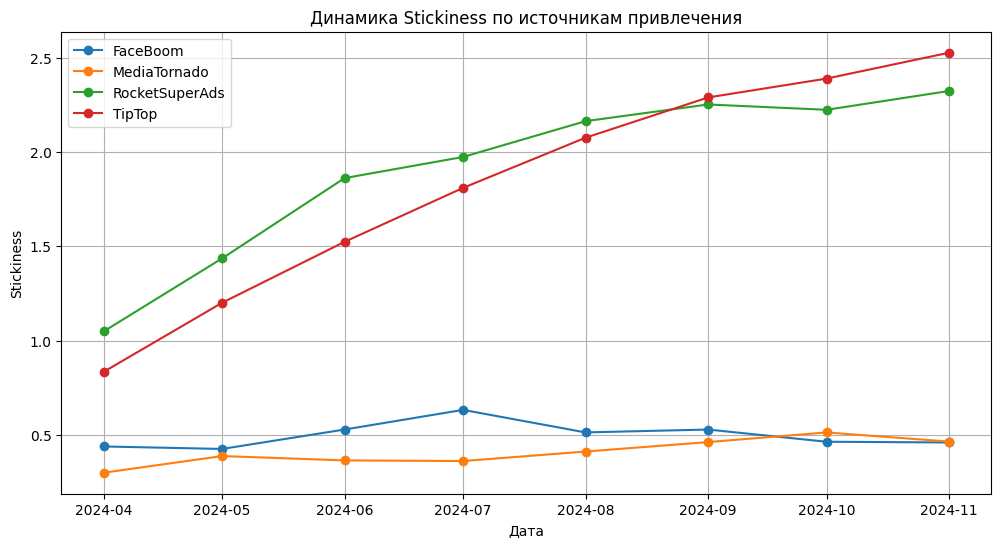

In [38]:
# Задача 1. Рассчитаем и визуализируем динамику Stickiness по источникам привлечения.

dau_per_channel['session_start']= dau_per_channel['event_dt'].dt.to_period('M').dt.to_timestamp()

dau_per_channel_mounthly_average = dau_per_channel.groupby(['session_start', 'first_channel'])['DAU'].mean().reset_index(name = 'DAU_mounthly_average')


stickiness = pd.merge(mau_per_channel, dau_per_channel_mounthly_average , on = ['session_start', 'first_channel'], how = 'left')
stickiness['Stickiness'] = stickiness['DAU_mounthly_average']/ stickiness['MAU']*100

plt.figure(figsize=(12,6))

for channel in stickiness['first_channel'].unique():
    df_plot = stickiness[stickiness['first_channel'] == channel]
    plt.plot(df_plot['session_start'], df_plot['Stickiness'], marker = 'o', label = channel)
plt.title('Динамика Stickiness по источникам привлечения')        
plt.xlabel('Дата')
plt.ylabel('Stickiness')
plt.legend()
plt.grid(True)
plt.show()

Промжуточный итог:
- Доля месячной активной аудитории самая высокая у каналов RocketSuperAds и TipTop.
- Самая низкая доля активной аудитории у каналов MediaTornado и FaceBoom.

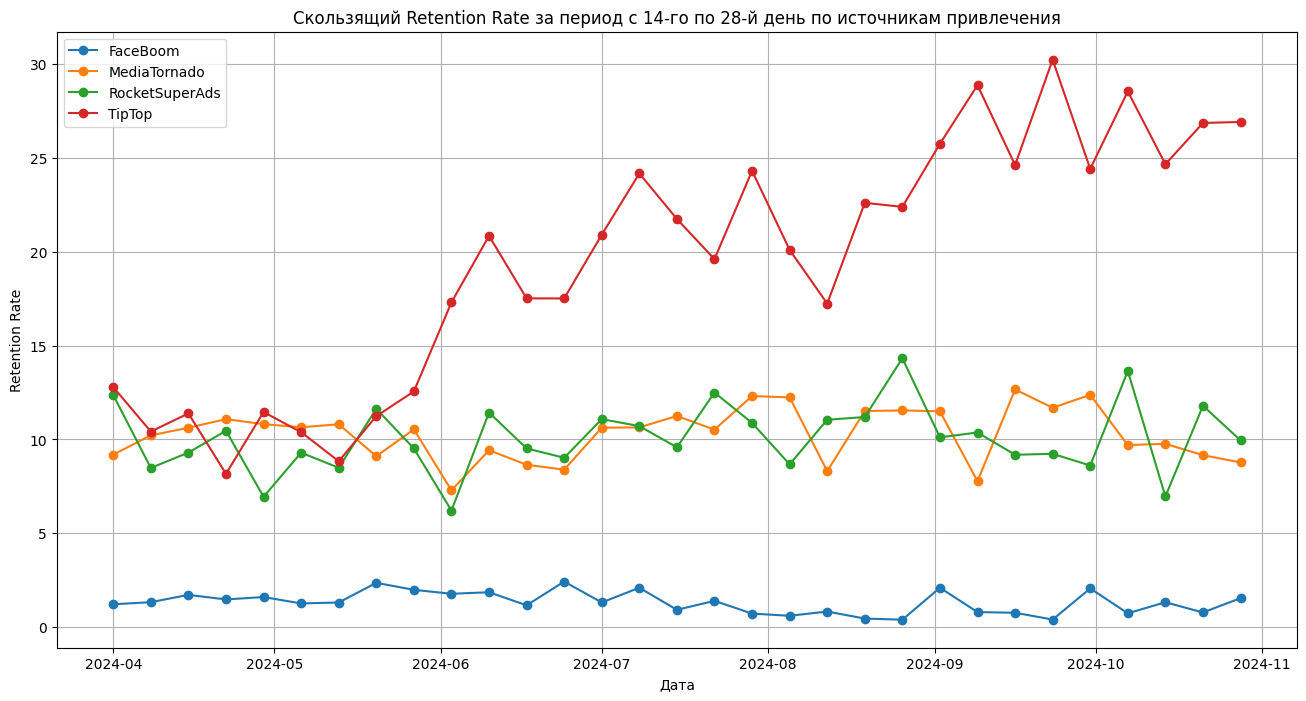

In [39]:
# Задача 2. Изучить динамику изменения метрик на 28-й день в разрезе источника. Провеcти анализ с выделением недельных когорт по дате привлечения. 
# Рассчитать и визуализировать скользящее удержание на 14-й день с момента привлечения (за период с 14-го по 28-й день).

# Выделяем недельную когорту в необходимый таблицах
profiles['week_cohort'] = profiles['first_dt'].dt.to_period('W').dt.to_timestamp()
visits['week_cohort'] = visits['first_dt'].dt.to_period('W').dt.to_timestamp()
orders['week_cohort'] = orders['first_dt'].dt.to_period('W').dt.to_timestamp()
costs['week_cohort'] = costs['dt'].dt.to_period('W').dt.to_timestamp()

# Фильтруем датасеты до 28 дней 
orders_28 = orders[(orders['lifetime']<28)&(orders['week_cohort'] < '2024-11-01')]
visits_28 = visits[(visits['lifetime']<28)&(visits['week_cohort'] < '2024-11-01')]

# Считаем количество пользователей за 0-ой период (на 28 день)
users_period_0 = visits_28.groupby(['week_cohort', 'first_channel'])['user_id'].nunique().reset_index(name = 'users_period_0')

# Считаем количество пользователей за период  14-го по 28-й день
users_period_14 = visits_28[visits_28['lifetime']>13].groupby(['week_cohort', 'first_channel'])['user_id'].nunique().reset_index(name = 'users_period_14')

# Создаем таблицу для дальнейшего расчета скользящего удержания
retention_rate = pd.merge(users_period_0, users_period_14, on = ['week_cohort', 'first_channel'], how = 'left').fillna(0)

# Считаем скользящее удержание
retention_rate['RR'] = retention_rate['users_period_14']/retention_rate['users_period_0']*100


# Визуялизируем метрику

plt.figure(figsize=(16,8))

for channel in retention_rate['first_channel'].unique():
    df_plot = retention_rate[retention_rate['first_channel'] ==channel] 
    plt.plot(df_plot['week_cohort'], df_plot['RR'], marker = 'o', label = channel)
    
plt.title('Скользящий Retention Rate за период с 14-го по 28-й день по источникам привлечения')
plt.xlabel('Дата')
plt.ylabel('Retention Rate')
plt.legend()
plt.grid()
plt.show()

Промежуточный итог:
- Самый высокий показатель удержание у канала TipTop. График имеет восходящий тренд, колебания. Самое высокое значение достигало 30%. Пользователи, пришедшие из этого канала наиболеезаинтересованы в продукте.
- Каналы MediaTornado и RocketSuperAds стабильны на протяжениии периода и держаться в районе значений приблизительно от 7 до 12%.
- Самый низкий показатель удержания у канала FaceBoom, хотя стабильный на протяжении всего периода. RR не достигает даже 5%. Пользователи, которые пришли в продукт из этого канала не сильно заинтересованы в продукте. 

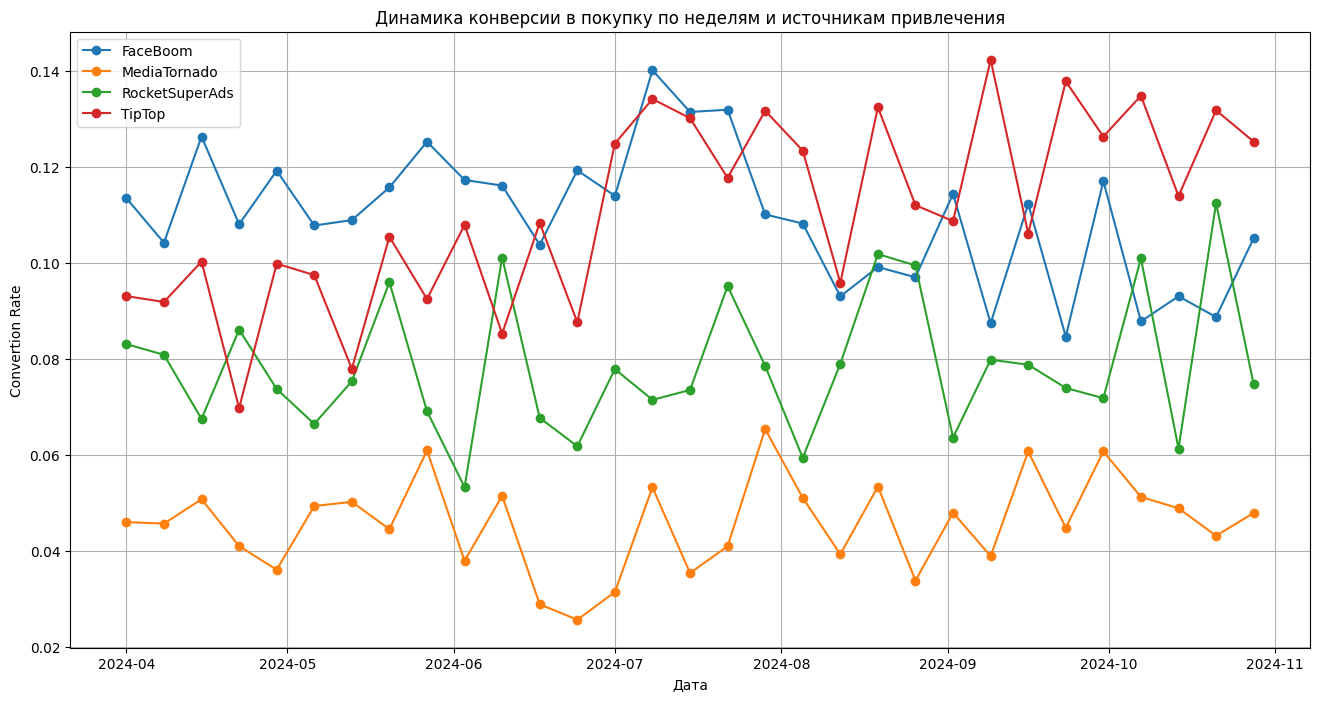

In [40]:
# Задача 2. Изучить динамику изменения метрик на 28-й день в разрезе источника. Провеcти анализ с выделением недельных когорт по дате привлечения. 
# Рассчитать и визуализировать конверсию в покупку.

# Считаем количество пользователей по неделям и канлам
CR_views = visits_28.groupby(['week_cohort', 'first_channel'])['user_id'].nunique().reset_index(name = 'CR_views')

# Считаем количество пользователей по неделям и каналам, которые совершали покупки
CR_purchase = orders_28.groupby(['week_cohort', 'first_channel'])['user_id'].nunique().reset_index(name = 'CR_purchase')

# Создаем таблицу для дальнейшего расчета конверсии
convertion_rate = pd.merge(CR_views, CR_purchase, on = ['week_cohort', 'first_channel'], how = 'left')

# Считаем конверсию в покупку
convertion_rate['CR'] = convertion_rate['CR_purchase']/convertion_rate['CR_views']

# Визуализируем метрику
plt.figure(figsize=(16,8))

for channel in convertion_rate['first_channel'].unique():
    df_plot = convertion_rate[convertion_rate['first_channel'] ==channel]
    plt.plot(df_plot['week_cohort'], df_plot['CR'], marker = 'o', label = channel)
    
plt.title('Динамика конверсии в покупку по неделям и источникам привлечения')    
plt.xlabel('Дата')
plt.ylabel('Convertion Rate')
plt.grid(True)
plt.legend()
plt.show()

Промежуточные итоги:
- Самый высокий показатель конверсии у каналов TipTop и FaceBoom. Если делать выводы в совокпуности с результатми удержания пользователей, то несмотря на высокую конверсию, из источника FaceBoom склонны делать разовые, импульсивные покупки. Это не тот, результат, к которому должны были привести маркетинговая стратегия: пользователи должны стабильно совершать покупки на протяжении всего времени, чтобы стать стабильным источником дохода компании. С каналом TipTop это было достигнуто, так как и удержание и конверсия в покупку имеют высокие показатели. Это означает, что пользователи сабильно совершают покупки в приложении, при этом доля этих пользователей высокая.
- RocketSuperAds относительно других источников привлечения имеет среднюю конверсию, в совокупности с удержанием показывает не самый худший результат.
- Канал MediaTornado имеет самую низкую конверсию в покупку, хотя удержание пользователей высокое. Для канала с неплохим удержанием стоит поработать над увеличением конверсии, так как получается, что пользователи остаются в риложении, но по каким-то причинам не заинтересованы в совершении покупок.

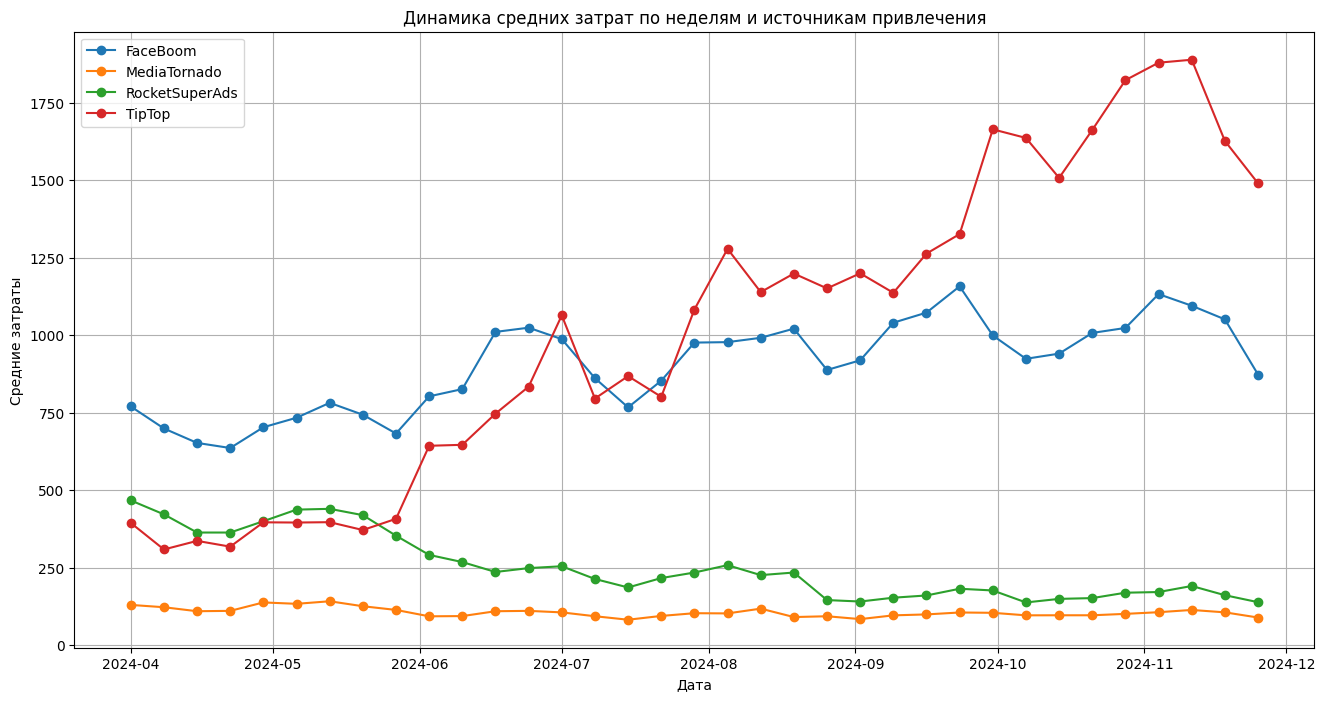

In [41]:
# Задача 2. Изучить динамику изменения метрик на 28-й день в разрезе источника. Провеcти анализ с выделением недельных когорт по дате привлечения. 
# Рассчитать и визуализировать динамику средних затрат на маркетинг.
cost_avg = costs.groupby(['week_cohort', 'channel'])['costs'].sum().reset_index(name = 'cost_avg')

# Визуализируем метрику
plt.figure(figsize=(16,8))

for channel in cost_avg['channel'].unique():
    df_plot = cost_avg[cost_avg['channel'] ==channel]
    plt.plot(df_plot['week_cohort'], df_plot['cost_avg'], marker = 'o', label = channel)
    
plt.title('Динамика средних затрат по неделям и источникам привлечения')    
plt.xlabel('Дата')
plt.ylabel('Средние затраты')
plt.grid(True)
plt.legend()
plt.show()

Промежуточные итоги:
- У канала привлечения TipTop график средних затрат имеет восходящий тренд и активно расти начал с июня и до конца года.
- Канала FaceBoom второй по величине средних затрат среди каналов, график также имеет восходящий тренд, но меньший, чем у графика канала TipTop. 
- Затраты на каналы RocketSuperAds и MediaBoom самые низкие, более стабильные, чем у предыдщих канало. С июля начинают постепенно снижаться. 

Более точная оценка будет возможно после анализа CAC, LTV и ROI, когда му узнаем, окупаются ли маркетинговые затраты у каналов.

In [42]:
# Задача 2. Изучить динамику изменения метрик на 28-й день в разрезе источника. Провеcти анализ с выделением недельных когорт по дате привлечения. 
# Рассчитать динамику значений CAC, LTV, ROI.

# Считаем среднее значение САС по неделям и каналам
cac = profiles.groupby(['week_cohort', 'first_channel'])['cac'].mean().reset_index(name = 'CAC_week')

# Считаем количество пользователей по неделям и каналам
ltv_users = profiles.groupby(['week_cohort', 'first_channel'])['user_id'].count().reset_index(name = 'ltv_users')

# Считаем сумму дохода по неделям и каналам
ltv_revenue = orders_28.groupby(['week_cohort', 'first_channel'])['revenue'].sum().reset_index(name = 'ltv_revenue')

# Сохраняем таблицу для расчета LTV
ltv = pd.merge(ltv_users, ltv_revenue, on = ['week_cohort', 'first_channel'], how = 'right')

# Считаем LTV
ltv['LTV_week'] = ltv['ltv_revenue']/ ltv['ltv_users']

# Сохраняем таблицу для расчета ROI
roi = pd.merge(ltv, cac[['week_cohort', 'first_channel', 'CAC_week']], on = ['week_cohort', 'first_channel'] , how = 'left')

# Считаем ROI
roi['ROI_week'] = (roi['LTV_week'] - roi['CAC_week'])/roi['CAC_week']*100

display(roi.head())

,week_cohort,first_channel,ltv_users,ltv_revenue,LTV_week,CAC_week,ROI_week
0,2024-04-01,FaceBoom,820,380.36,0.463854,0.938873,-50.594635
1,2024-04-01,MediaTornado,522,191.43,0.366724,0.247736,48.030068
2,2024-04-01,RocketSuperAds,542,724.33,1.336402,0.860978,55.219115
3,2024-04-01,TipTop,516,795.40,1.541473,0.763545,101.883614
4,2024-04-08,FaceBoom,749,337.06,0.450013,0.933074,-51.770905


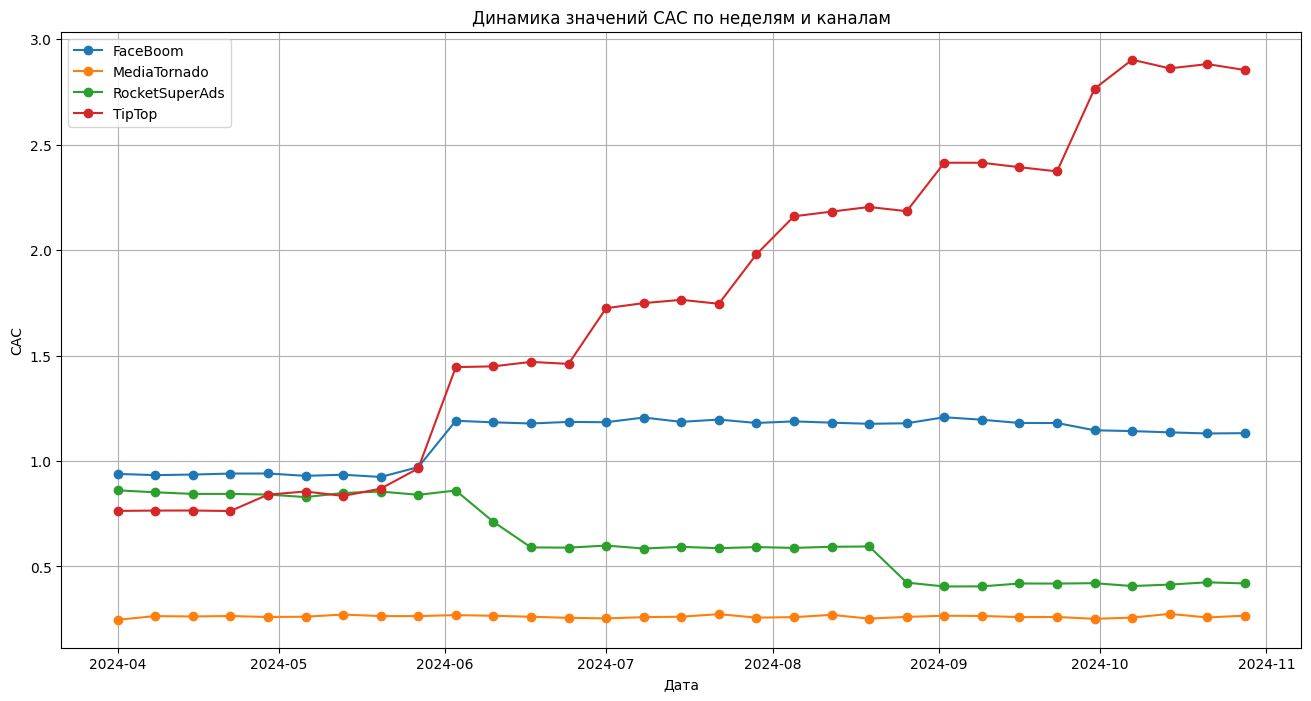

In [43]:
# Задача 2. Изучить динамику изменения метрик на 28-й день в разрезе источника. Провеcти анализ с выделением недельных когорт по дате привлечения. 
# Визуализировать динамику значений CAC


# Визуализируем метрику
plt.figure(figsize=(16,8))
for channel in roi['first_channel'].unique():
    df_plot = roi[roi['first_channel'] ==channel]
    plt.plot(df_plot['week_cohort'], df_plot['CAC_week'], marker = 'o', label = channel)
    
plt.title('Динамика значений САС по неделям и каналам')    
plt.xlabel('Дата')
plt.ylabel('САС')
plt.grid(True)
plt.legend()
plt.show()

Промежуточные итоги:
- Значение САС у канала TipTop на временном промежутке растет, график имеет восходящий тренд и скачок произошел в начале лета. График имеет колебания. У данного канала самые высокие значения метрики среди каналов. 
- График канала FaceBoom стабилен на протяжении периода, имеет один небольшой скачок роста в июне. 
- График RocketSuperAds имеет нисходящий тренд и две точки снижения графика в июне и конце августа. В целом график стабилен. 
-  График САС MediaBoom стабилен и имеет наиболее низкие значения. 

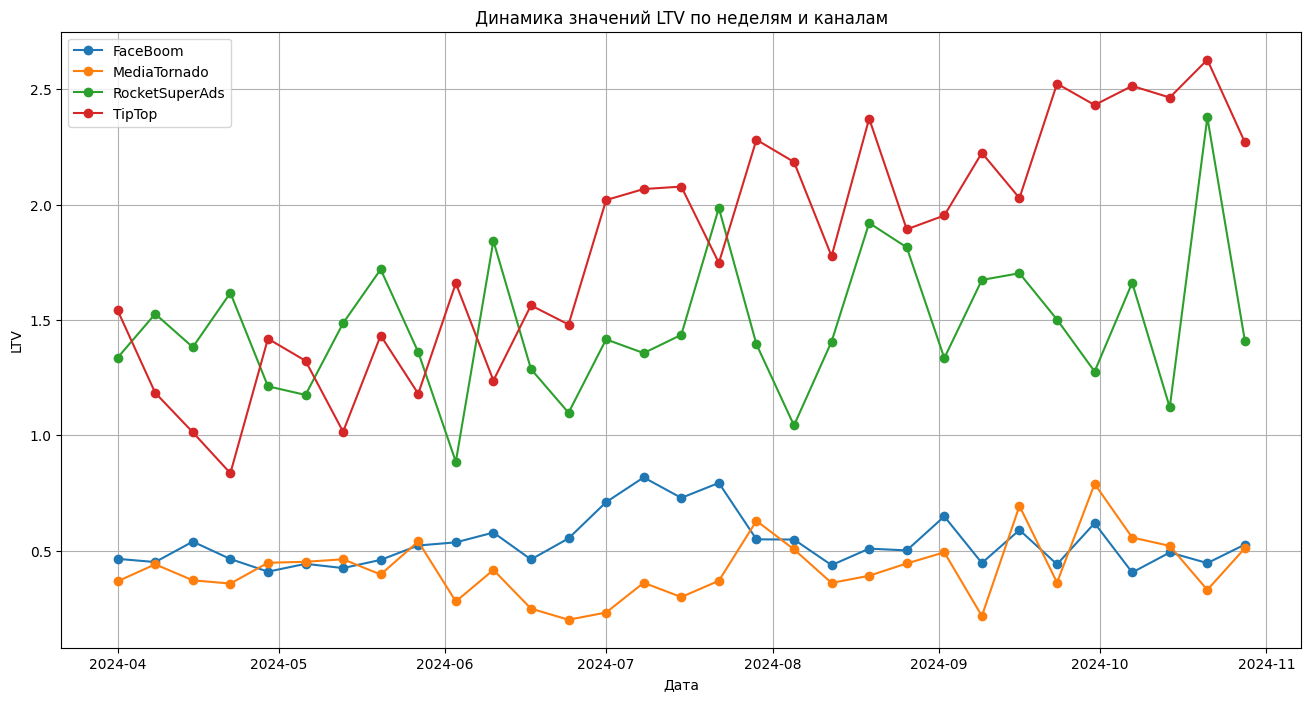

In [44]:
# Задача 2. Изучить динамику изменения метрик на 28-й день в разрезе источника. Провеcти анализ с выделением недельных когорт по дате привлечения. 
# Визуализировать динамику значений LTV

# Визуализируем метрику
plt.figure(figsize=(16,8))
for channel in roi['first_channel'].unique():
    df_plot = roi[roi['first_channel'] ==channel]
    plt.plot(df_plot['week_cohort'], df_plot['LTV_week'], marker = 'o', label = channel)
    
plt.title('Динамика значений LTV по неделям и каналам')    
plt.xlabel('Дата')
plt.ylabel('LTV')
plt.grid(True)
plt.legend()
plt.show()

Промежуточные итоги:
- График LTV у канала TipTop имеет восходящий тренд и колебания.
- График канала FaceBoom стабилен на протяжении периода, имеет небольшие колебания. Значение LTV достаточно низкие.
- График RocketSuperAds имеет колебания и неплохие значения LTV в сравнение с затратами, которые были у данного канала. 
-  График LTV MediaBoomстабилен на протяжении периода, имеет небольшие колебания. Близок по значению к каналу FaceBoom.

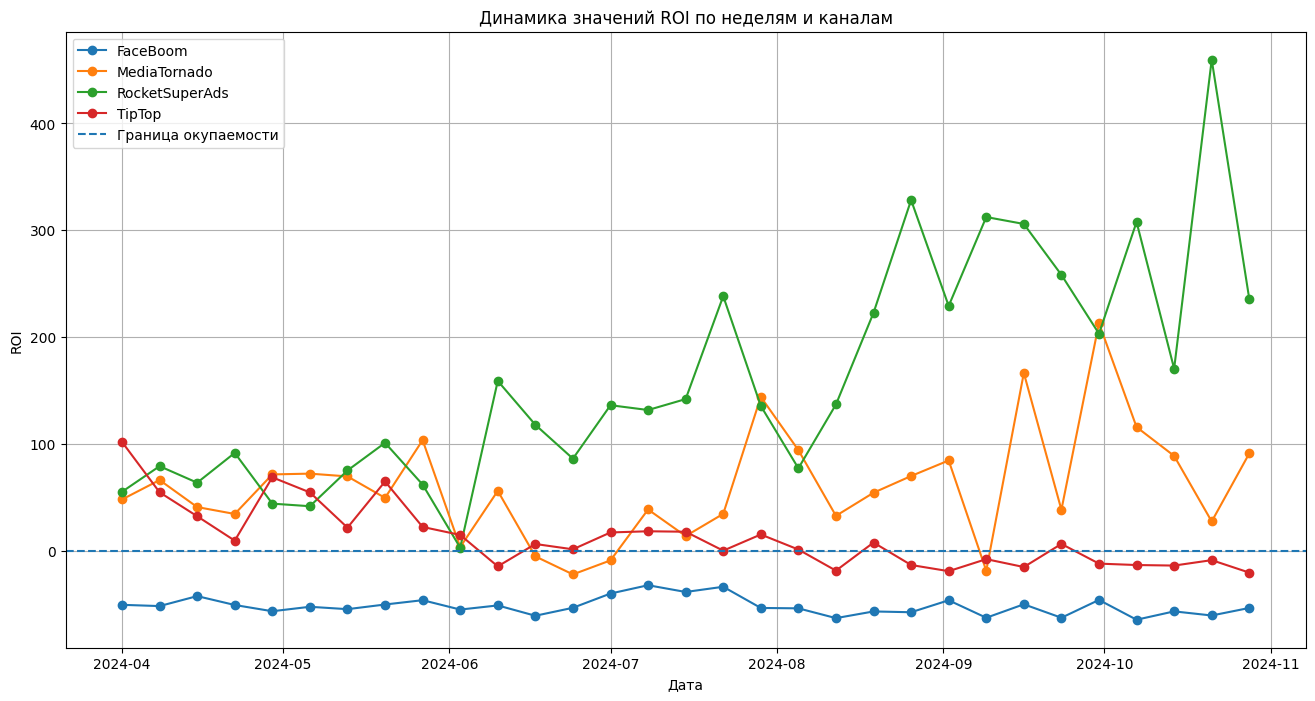

In [45]:
# Задача 2. Изучить динамику изменения метрик на 28-й день в разрезе источника. Провеcти анализ с выделением недельных когорт по дате привлечения. 
# Визуализировать динамику значений  ROI.

# Визуализируем метрику
plt.figure(figsize=(16,8))
for channel in roi['first_channel'].unique():
    df_plot = roi[roi['first_channel'] ==channel]
    plt.plot(df_plot['week_cohort'], df_plot['ROI_week'], marker = 'o', label = channel)
    
plt.axhline(y=0, linestyle='--', label='Граница окупаемости')
    
plt.title('Динамика значений ROI по неделям и каналам')    
plt.xlabel('Дата')
plt.ylabel('ROI')
plt.grid(True)
plt.legend()
plt.show()

Промежуточные итоги:
- График ROI у канала TipTop окупался до изменения маркетинговой стратегии, после затраты на этот канал перестали себя оправлывать, какнал нерентабельный.
- График канала FaceBoom вообще не окупается, самый невыгодный и неэффективный канал. 
- График RocketSuperAds окупается на протяжении всего периода, после изменения маркетинговой стартегии имеет самые высокие показатели рентабельности среди каналов. 
-  График ROI MediaBoom нестабилен в вопрсое окупаемости, сложно проследить зависимость значений от времени. 

Промежуточные выводы по 4 блоку:

- TipTop: Несмотря на хорошие показатели удержания и конверсии в покупку, затраты на данный канал слишком высокие и LTV не покрывает их. График ROI практически не пересекает границу окупаемости после изменения маркетинговой стратегии, что свидетельствует о неэффективной работе канала. Стоит снизить затраты на канал и увеличить доходы с клиента, так как трафик у канала хороший, вовлеченность пользоателей высокая и терять ее будет также неэффективно.

- FaceBoom: Самый неэффективный канал продвижения, уровень вовлеченности низкий, пользователи совершают разовые покупки и не задерживаются в продукте. Доход с него нестабильный. Канал не рентабельный на протяжении всего периода, график ROI ни разу не пересек границу окупаемости. Стоит пересмотреть планы продвижения через FaceBoom и перенаправить ресурсы на более рентабельный канал или основательно поменять стратегию продвижения через этот канал. 

- RocketSuperAds: Единсвтенный канал, полностью окупивший себя на протяжении всего периода. Несмотря на средние, хотя и стабильные значения удержания и конверсии в покупку, у канала низкий CAC (который снизился еще и после введения новой маркетинговой стратегии) и высокий LTV, который покрывает затраты. Можно попробовать увелчить затраты на канал и посмотреть на его динамику LTV и рентабельность, а также стараться увеличить удержание и конверсию до более высоких показателей. 

- MediaBoom: У канала никзие значения удержания и конверсии в покупку, но вместе с тем самые низкие затраты, что позволяет тоже не очень высокому LTV покрывать затраты. График ROI нестабильный, но часто находится в зоне окупаемости. Учитывая минимальные затратами, канал показал не самеы худшие результаты и возможнос стоит обратить на него внимание и постараться увеличить вовлеченность и конверсию, чтобы привлечь пользователей на долгосрочной основе и стабилизировать график ROI. 

## Анализ периода окупаемости маркетинговых вложений

Для источников, которые к 28-му дню не выходят на уровень окупаемости, рассчитаем и визуализируем в виде тепловой карты значения ROI за больший период, например за 8–10 недель.

Разделим данные на недельные когорты по дате привлечения, в качестве интервала наблюдений используем недели.

Сделаем вывод о том, за какой период окупаются вложения в эти источники.

In [46]:
# Создаем недельные когорты
orders['event_week'] = orders['event_dt'].dt.to_period('W').dt.to_timestamp()
orders['week_cohort'] = orders['first_dt'].dt.to_period('W').dt.to_timestamp()  # ← переименовано в week_cohort
visits['week_cohort'] = visits['first_dt'].dt.to_period('W').dt.to_timestamp()  # ← переименовано в week_cohort
profiles['week_cohort'] = profiles['first_dt'].dt.to_period('W').dt.to_timestamp()  # ← переименовано в week_cohort

# Рассчитываем номер недели
orders['N_week'] = ((orders['event_week'] - orders['week_cohort']).dt.days / 7).astype(int)

# Рассчитываем CAC по недельным когортам
cac = profiles.groupby(['week_cohort', 'first_channel'])['cac'].mean().reset_index(name='CAC_week')

# Считаем количество пользователей в каждой когорте
ltv_users = profiles.groupby(['week_cohort', 'first_channel'])['user_id'].nunique().reset_index(name='ltv_users')

# Считаем кумулятивную выручку за 8 недель (исправленная версия)
ltv_revenue_cum = (
    orders[orders['N_week'] < 10]
    .groupby(['week_cohort', 'first_channel', 'N_week'])['revenue']
    .sum()  # ← используем sum() вместо cumsum()
    .groupby(['week_cohort', 'first_channel'])
    .cumsum()  # ← cumsum() применяем после группировки
    .reset_index(name='ltv_revenue_cum')
)

# Объединяем данные
ltv_10 = pd.merge(ltv_users, ltv_revenue_cum, on=['week_cohort', 'first_channel'], how='left')

# Рассчитываем LTV
ltv_10['LTV_10'] = ltv_10['ltv_revenue_cum'] / ltv_10['ltv_users']

# Объединяем с CAC
roi_10 = pd.merge(ltv_10, cac[['week_cohort', 'first_channel', 'CAC_week']], 
                  on=['week_cohort', 'first_channel'], how='left')

# Рассчитываем ROI
roi_10['ROI_10'] = (roi_10['LTV_10'] - roi_10['CAC_week']) / roi_10['CAC_week'] * 100

display(roi_10)

,week_cohort,first_channel,ltv_users,N_week,ltv_revenue_cum,LTV_10,CAC_week,ROI_10
0,2024-04-01,FaceBoom,820,0,290.63,0.354427,0.938873,-62.249760
1,2024-04-01,FaceBoom,820,1,353.44,0.431024,0.938873,-54.091302
2,2024-04-01,FaceBoom,820,2,374.38,0.456561,0.938873,-51.371383
3,2024-04-01,FaceBoom,820,3,380.36,0.463854,0.938873,-50.594635
4,2024-04-01,FaceBoom,820,6,383.35,0.467500,0.938873,-50.206261
...,...,...,...,...,...,...,...,...
1106,2024-11-18,TipTop,567,1,880.49,1.552892,2.869575,-45.884231
1107,2024-11-25,FaceBoom,763,0,278.22,0.364640,1.144146,-68.129992
1108,2024-11-25,MediaTornado,341,0,46.36,0.135953,0.259804,-47.670917
1109,2024-11-25,RocketSuperAds,331,0,136.07,0.411088,0.417296,-1.487783


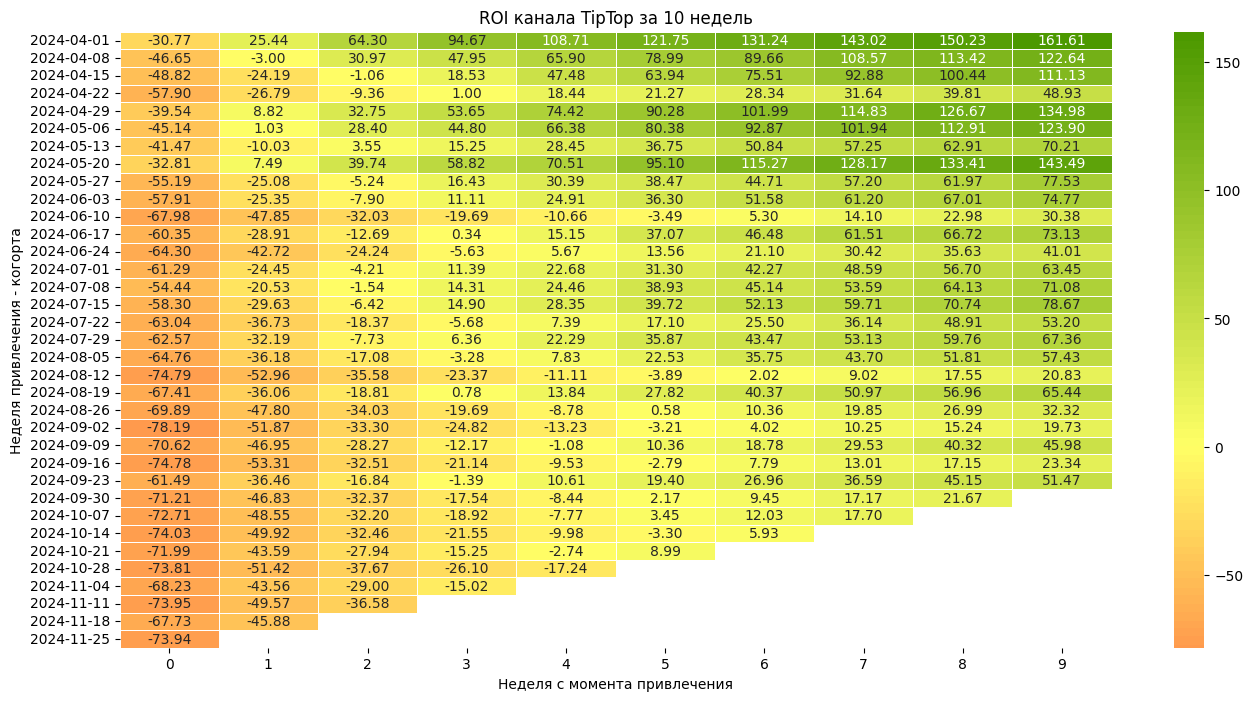

In [47]:
# Визуализируем ROI для TipTop

cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)

roi_10['week_cohort'] = roi_10['week_cohort'].astype('datetime64[ns]').dt.strftime('%Y-%m-%d')

roi_tip_top = roi_10[roi_10['first_channel']== 'TipTop']
pivot_tip_top = roi_tip_top.pivot(index = 'week_cohort', columns = 'N_week', values = 'ROI_10')

plt.figure(figsize=(16,8))

sns.heatmap(pivot_tip_top,
    annot=True,
    fmt='.2f',
    cmap=cmap,
    center=0,
    linewidths=0.5)
plt.title('ROI канала TipTop за 10 недель')
plt.xlabel('Неделя с момента привлечения')
plt.ylabel('Неделя привлечения - когорта')
plt.show()

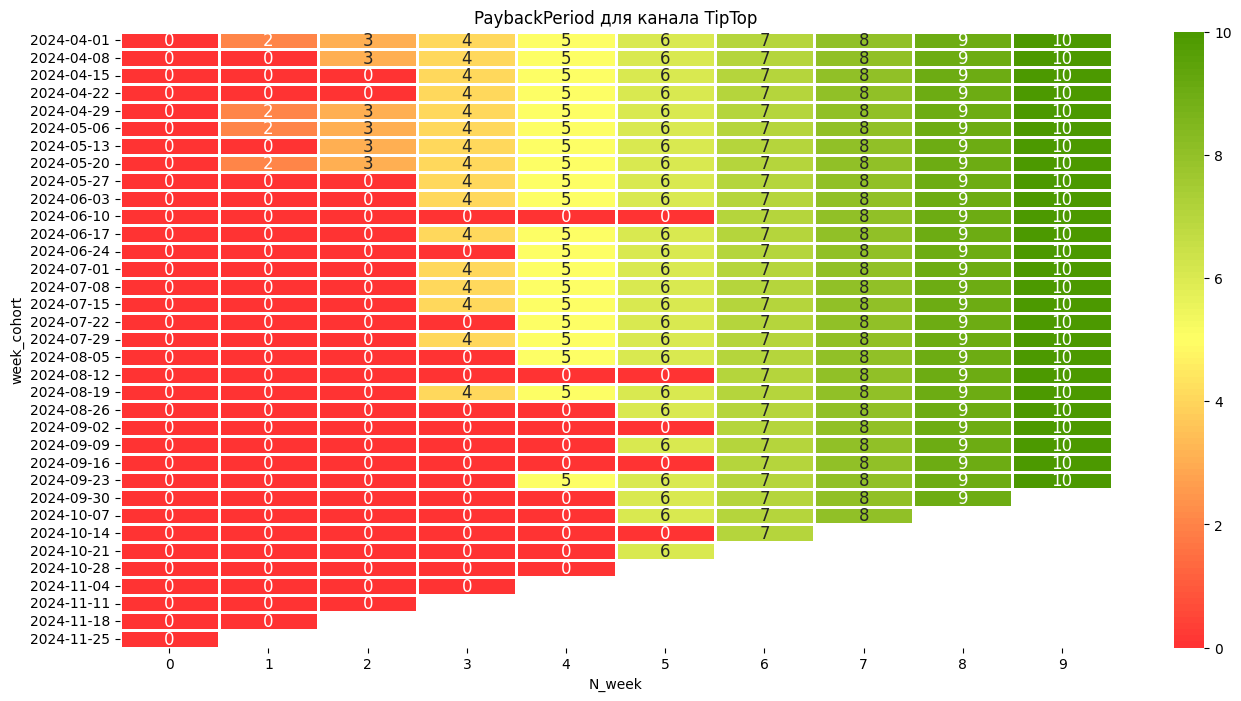

In [48]:
# Рассчитаем и визуализируем Payback Period для TipTop

roi_10_gr_tip_top = roi_10[roi_10['first_channel']=='TipTop'][['week_cohort', 'first_channel', 'N_week','LTV_10', 'CAC_week']].copy()


roi_10_gr_tip_top['Payback_Period'] = roi_10_gr_tip_top.apply(lambda row: row['N_week'] + 1 if row['LTV_10']>=row['CAC_week'] else 0, axis=1)

pivot_roi_10_gr_tip_top = roi_10_gr_tip_top.pivot(index='week_cohort', columns = 'N_week', values = 'Payback_Period')

plt.figure(figsize=(16, 8))

sns.heatmap(pivot_roi_10_gr_tip_top,
          cmap=cmap,
          annot=True,
          fmt='.0f',
          linewidths=2,
          annot_kws={"size": 12})


plt.title('PaybackPeriod для канала TipTop')
plt.xlabel('N_week')
plt.ylabel('week_cohort')
plt.show()

Промежуточный период:
- Полностью канал TipTop начинает окупаться к 7 неделе после привлечения. Канал не безнадежен и с ним можно продолжать работать с определенными корреткировками в стратегии.

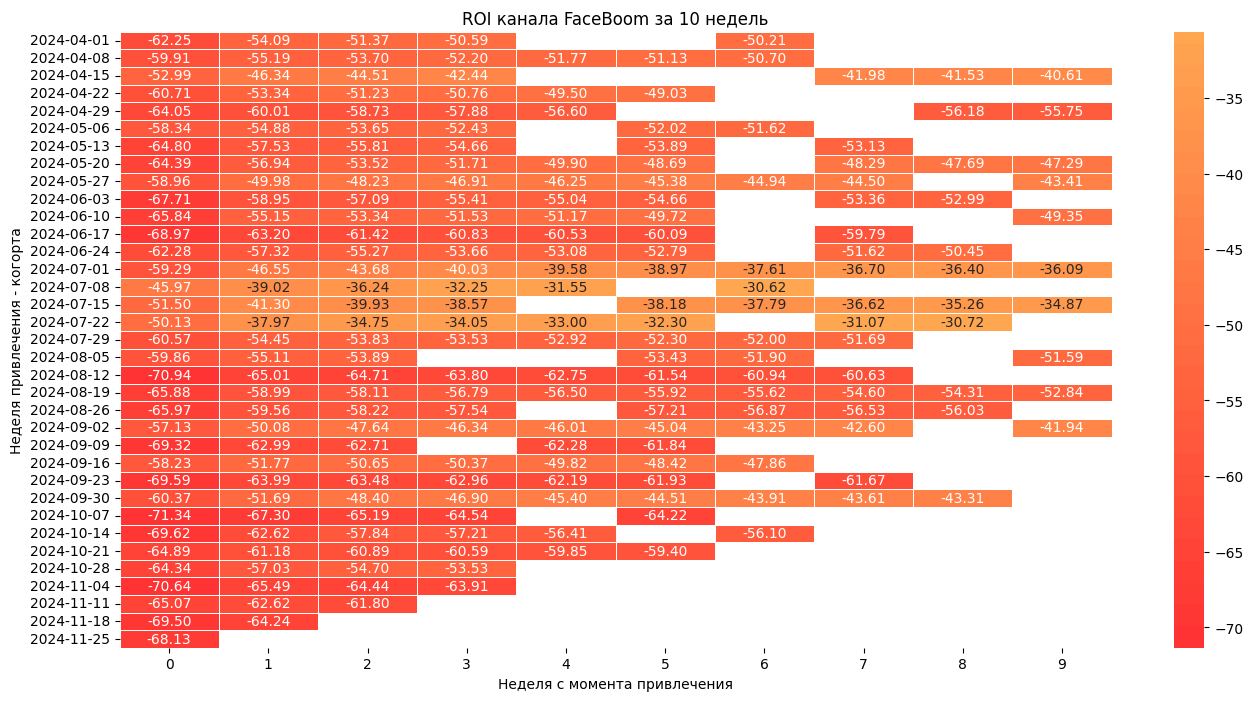

In [49]:
# Визуализируем ROI для FaceBoom

roi_10['week_cohort'] = roi_10['week_cohort'].astype('datetime64[ns]').dt.strftime('%Y-%m-%d')

roi_tip_top = roi_10[roi_10['first_channel']== 'FaceBoom']
pivot_tip_top = roi_tip_top.pivot(index = 'week_cohort', columns = 'N_week', values = 'ROI_10')

plt.figure(figsize=(16,8))

sns.heatmap(pivot_tip_top,
    annot=True,
    fmt='.2f',
    cmap=cmap,
    center=0,
    linewidths=0.5)
plt.title('ROI канала FaceBoom за 10 недель')
plt.xlabel('Неделя с момента привлечения')
plt.ylabel('Неделя привлечения - когорта')
plt.show()

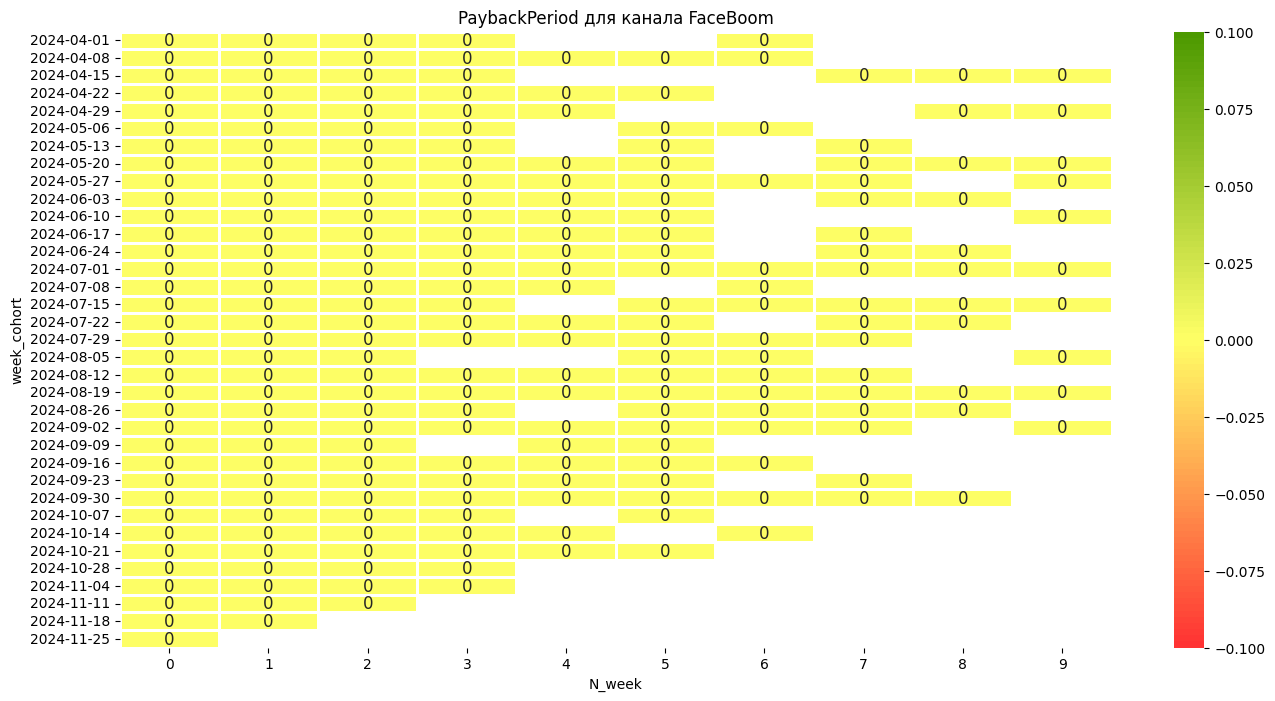

In [50]:
# Рассчитаем и визуализируем Payback Period для FaceBoom

roi_10_gr_faceboom = roi_10[roi_10['first_channel']=='FaceBoom'][['week_cohort', 'first_channel', 'N_week','LTV_10', 'CAC_week']].copy()


roi_10_gr_faceboom['Payback_Period'] = roi_10_gr_faceboom.apply(lambda row: row['N_week'] + 1 if row['LTV_10']>=row['CAC_week'] else 0, axis=1)

roi_10_gr_faceboom = roi_10_gr_faceboom.pivot(index='week_cohort', columns = 'N_week', values = 'Payback_Period')

plt.figure(figsize=(16, 8))

sns.heatmap(roi_10_gr_faceboom,
          cmap=cmap,
          annot=True,
          fmt='.0f',
          linewidths=2,
          annot_kws={"size": 12})


plt.title('PaybackPeriod для канала FaceBoom')
plt.xlabel('N_week')
plt.ylabel('week_cohort')
plt.show()

Промежуточные итоги:
- Канал продвижения FaceBoom не окупается вообще, в него лучше не вкладываться.

## Выводы и рекомендации

Основыне результаты: 
Продуктом в целом пользуется на постоянной основе, это понятно по графику метрики Stickiness, который имеет восходящий тренд. 
Если анализировать период, когда начала работать новая схема привлечения и маркетинговая стратегия, то можем заметить, что график общего ROI (для покупок, совершенны за 28 дней с момента привлечения) пересекает границе окупаемости только в июле, то есть имеются некоторые проблемы в работе некоторых каналов привлечения. 

Характеристика каналов привлечения:
- TipTop: Несмотря на хорошие показатели удержания и конверсии в покупку, затраты на данный канал слишком высокие и LTV не покрывает их. График ROI практически не пересекает границу окупаемости после изменения маркетинговой стратегии, что свидетельствует о неэффективной работе канала. Стоит снизить затраты на канал и увеличить доходы с клиента, так как трафик у канала хороший, вовлеченность пользоателей высокая и терять ее будет также неэффективно.

- FaceBoom: Самый неэффективный канал продвижения, уровень вовлеченности низкий, пользователи совершают разовые покупки и не задерживаются в продукте. Доход с него нестабильный. Канал не рентабельный на протяжении всего периода, график ROI ни разу не пересек границу окупаемости. Стоит пересмотреть планы продвижения через FaceBoom и перенаправить ресурсы на более рентабельный канал или основательно поменять стратегию продвижения через этот канал. 

- RocketSuperAds: Единсвтенный канал, полностью окупивший себя на протяжении всего периода. Несмотря на средние, хотя и стабильные значения удержания и конверсии в покупку, у канала низкий CAC (который снизился еще и после введения новой маркетинговой стратегии) и высокий LTV, который покрывает затраты. Можно попробовать увелчить затраты на канал и посмотреть на его динамику LTV и рентабельность, а также стараться увеличить удержание и конверсию до более высоких показателей. 

- MediaBoom: У канала никзие значения удержания и конверсии в покупку, но вместе с тем самые низкие затраты, что позволяет тоже не очень высокому LTV покрывать затраты. График ROI нестабильный, но часто находится в зоне окупаемости. Учитывая минимальные затратами, канал показал не самеы худшие результаты и возможнос стоит обратить на него внимание и постараться увеличить вовлеченность и конверсию, чтобы привлечь пользователей на долгосрочной основе и стабилизировать график ROI.


Дополнительная характеристика каналов, которые не окупается к 28 дню с момента привлечения. 
- TipTop: полностью окупаться начинает к 7 неделе после привлечения. Канал не безнадежен, в целом он работает, просто очень долго выходит на уровень окупаемости. 

- FaceBoom: не окупается ни к 7, ни к 9 неделе с момента привлечения. 

Рекомендации:
В целом маркетинговая стратегия хорошо работает с каналами RocketSuperAds, так как это единственный канал, который полностью окупается за период. Канал MediaBoom несмотря на небольшие затраты и охваты, показывает не самые худшие показатели окупаемости, хоть и нестабильные. Возможно стоит провести дополнительные исследования и выяснить причины такому поведению более детально. Канал TipTop имеет более стабильные, но низкие показатели, стоит увеличивать LTV или уменьшать CAC, чтобы сокращать PayBack Period. Канал FaceBoom не рентабельный и стоит перенаправить затраты на другие каналы.